**базовые модели ML**

Евгений Борисов <esborisov@sevsu.ru>

решение задачи бинарной классификации

----

In [1]:
# # показывать выдачу всех строк ячейки
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import numpy as np
import numpy.random as rng
# import pandas as pd
# from tqdm import tqdm
# from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [3]:
# tqdm.pandas ()
# pd.options.display.float_format = '{:,.2f}'.format

In [4]:
import sys 
import logging

logging.basicConfig(
    format=u'[%(levelname)-8s] %(asctime)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.DEBUG,
    stream=sys.stdout,
    )

## генерируем датасет

In [11]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X,target = make_blobs( n_samples=1_000, centers=2, cluster_std=[1.7,1.8] )
print( X.shape,target.shape )

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.33)
X_train, X_val, target_train, target_val = train_test_split(X_train, target_train, test_size=0.33)

del X,target

(1000, 2) (1000,)


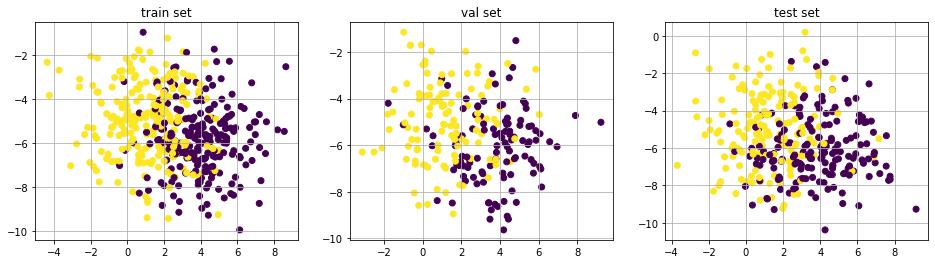

In [12]:
fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(16,4))
ax0.scatter(X_train[:,0],X_train[:,1],c=target_train)
ax0.grid()
ax0.set_title('train set')

ax1.scatter(X_val[:,0],X_val[:,1],c=target_val)
ax1.set_title('val set')
ax1.grid()

ax2.scatter(X_test[:,0],X_test[:,1],c=target_test)
ax2.set_title('test set')
ax2.grid()

## LinearModel  + MSQE + GD

In [13]:
# преобразуем список меток к размерности выхода модели
y_train = np.eye(target_train.max()+1)[target_train]
y_val = np.eye(target_val.max()+1)[target_val]
y_test = np.eye(target_test.max()+1)[target_test]
y_train.shape,y_val.shape,y_test.shape

((448, 2), (222, 2), (330, 2))

In [14]:
from lib.initiator.linear import UniformInitiatorLinearModel
# UniformInitiatorLinearModel(input_size,output_size)

In [15]:
from lib.model.linear import LinearModel # простая линейная модель x.dot(w)
# LinearModel(initiator)
model = LinearModel(
    initiator=UniformInitiatorLinearModel(
    #initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=y_train.shape[1],
    )
)

model.weight.shape

(2, 2)

In [16]:
from lib.loss.msqe import MSQE # ф-ция потери - cреднеквадратическое отклонение
loss = MSQE(model)

In [17]:
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная
lra = ConstLRA(.01)

In [18]:
from lib.optimizer.gd import GD # метод оптимизации градиентный спуск
# GD(loss,lra=ConstLRA(.1),breaker=Breaking(),regul=Regularization(1.),momentum=0.) 
# GD.fit(data_train,data_val=None,n_epoch=2)

In [19]:
model = GD(
    loss=loss,
    lra=lra,
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=15,
)

100%|██████████| 15/15 [00:00<00:00, 1458.92it/s, loss=1.03, lr=0.01]


Threshold value is:0.0036783057734628938

              precision    recall  f1-score   support

           0       0.52      0.97      0.68       171
           1       0.50      0.03      0.06       159

    accuracy                           0.52       330
   macro avg       0.51      0.50      0.37       330
weighted avg       0.51      0.52      0.38       330



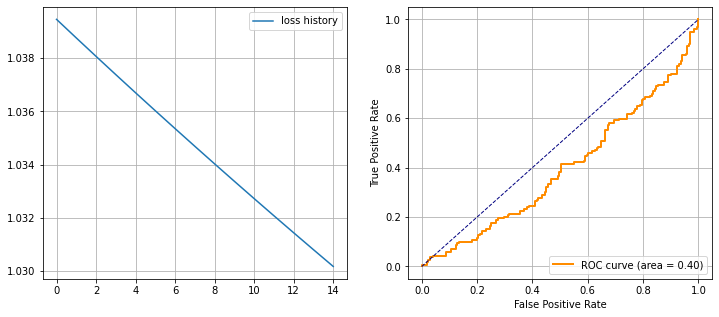

In [20]:
from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
# ClassifierEstimator(target,predict_score,loss_history)

ClassifierEstimator(
    target=target_test, 
    predict_score=model.predict(X_test)[:,0],  
    loss_history=loss.history, 
).estimate()

## LogisticRegression + BCE + SGD

In [21]:
# преобразуем список меток к размерности выхода модели
y_train = target_train[:,np.newaxis]
y_val = target_val[:,np.newaxis]
y_test = target_test[:,np.newaxis]
y_train.shape,y_val.shape,y_test.shape

((448, 1), (222, 1), (330, 1))

In [22]:
from lib.initiator.linear import NormalInitiatorLinearModel
# NormalInitiatorLinearModel(input_size,output_size)

In [23]:
from lib.model.linear import LogisticRegression # логистическая регрессия 1./(1.+np.exp(-x.dot(w)) )
# LogisticRegression(n_features=0)

model = LogisticRegression(
    initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
    )
)

model.weight.shape


(2, 1)

In [24]:
from lib.loss.crossentropy import BCE # ф-ция потери - кросс-энтропия
loss = BCE(model)

In [25]:
from lib.optimizer.lrate import FactorLRA # скорость обучения - уменьшается в процессе обучения
# FactorLRA(start,bound,factor,)
lra = FactorLRA(.5,bound=.01,factor=.9,)

In [26]:
from lib.optimizer.breaker import EarlyStopping # прерывание при достижении прога значения ф-ции потери
# EarlyStopping( bound=None, min_delta=0., max_delta=None, patience=2 )
es = EarlyStopping(bound=1e-2)

In [27]:
from lib.optimizer.regularizator import RegularizationL1 # регуляризация
# RegularizationL1(rho)
reg = RegularizationL1(rho=.01)

In [28]:
from lib.optimizer.gd import SGD # метод  оптимизации стохастический градиентный спуск 
# SGD(loss,lra=ConstLRA(.1),breaker=Breaking(),regul=Regularization(1.),momentum=0.)
# SGD.fit(data_train,batch_size, data_val=None,n_epoch=2,target_is_indices=False):

In [29]:
model = SGD(
    loss=loss,
    lra=lra,
    breaker=es,
    regul=reg,
    momentum=.01,    
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=15,
    batch_size=y_train.shape[0]//10,
)

100%|██████████| 15/15 [00:00<00:00, 593.46it/s, loss=0.688, lr=0.114]


Threshold value is:0.4831719803102104

              precision    recall  f1-score   support

           0       0.74      0.75      0.74       171
           1       0.73      0.72      0.72       159

    accuracy                           0.73       330
   macro avg       0.73      0.73      0.73       330
weighted avg       0.73      0.73      0.73       330



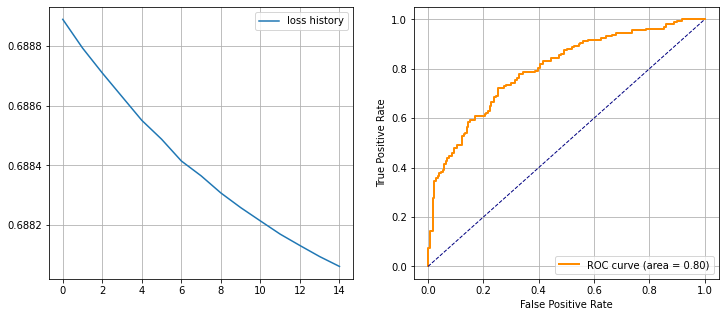

In [30]:
from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
# ClassifierEstimator(target,predict_score,loss_history)

ClassifierEstimator(
    target=target_test, 
    predict_score=model.predict(X_test)[:,0],  
    loss_history=loss.history, 
).estimate()

## Softmax  + CCE + SGD

In [40]:
# преобразуем список меток к размерности выхода модели
y_train = np.eye(target_train.max()+1)[target_train]
y_val = np.eye(target_val.max()+1)[target_val]
y_test = np.eye(target_test.max()+1)[target_test]
y_train.shape,y_val.shape,y_test.shape

((448, 2), (222, 2), (330, 2))

In [41]:
from lib.initiator.linear import NormalInitiatorLinearModel
# NormalInitiatorLinearModel(input_size,output_size)

In [51]:
from lib.model.linear import Softmax 

# LinearModel(initiator)
model = Softmax(
    initiator=UniformInitiatorLinearModel(
    # initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=y_train.shape[1],
    )
)

model.weight.shape

(2, 2)

In [52]:
from lib.loss.crossentropy import CCE # ф-ция потери - категориальная кросс-энтропия
loss = CCE(model)

#from lib.optimizer.lrate import FactorLRA # скорость обучения - уменьшается в процессе обучения
# FactorLRA(start,bound,factor,)
# lra = FactorLRA(.5,bound=.01,factor=.9,)
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная
lra = ConstLRA(.01)


#from lib.optimizer.breaker import EarlyStopping # прерывание при достижении прога значения ф-ции потери
# EarlyStopping( bound=None, min_delta=0., max_delta=None, patience=2 )
#es = EarlyStopping(bound=1e-2)

from lib.optimizer.regularizator import RegularizationL1 # регуляризация
# RegularizationL1(rho)
reg = RegularizationL1(rho=.01)

from lib.optimizer.gd import SGD # метод  оптимизации стохастический градиентный спуск 
# SGD(loss,lra=ConstLRA(.1),breaker=Breaking(),regul=Regularization(1.),momentum=0.)
# SGD.fit(data_train,batch_size, data_val=None,n_epoch=2,target_is_indices=False):

In [53]:
model = SGD(
    loss=loss,
    lra=lra,
    #breaker=es,
    regul=reg,
    momentum=.01,    
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=15,
    batch_size=y_train.shape[0]//10,
)

100%|██████████| 15/15 [00:00<00:00, 417.42it/s, loss=-.697, lr=0.01]


In [54]:
from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
# ClassifierEstimator(target,predict_score,loss_history)

Threshold value is:0.4866422703915601

              precision    recall  f1-score   support

           0       0.72      0.66      0.69       171
           1       0.67      0.73      0.70       159

    accuracy                           0.69       330
   macro avg       0.70      0.70      0.69       330
weighted avg       0.70      0.69      0.69       330



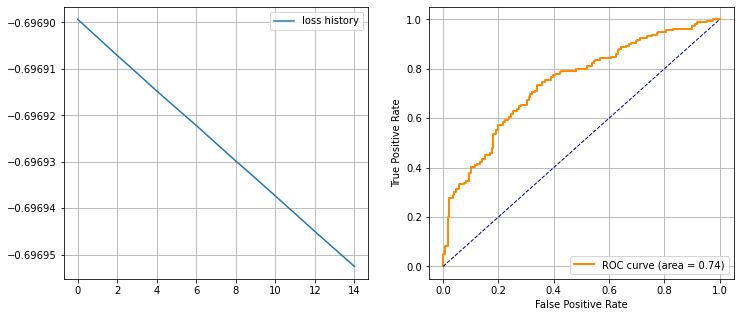

In [55]:
ClassifierEstimator(
    target=target_test, 
    predict_score=model.predict(X_test)[:,0],  
    loss_history=loss.history, 
).estimate()

---

In [ ]:
## FactorLRA

In [ ]:
# from lib.optimizer.lrate import ConstLRA
# lr =  ConstLRA(.1)
# [ lr.next() for _ in range(100) ]
# lr.history

In [ ]:
# from lib.optimizer.lrate import FactorLRA
# lr =  FactorLRA(value=.9,bound=.01,factor=.9,)
# v = [ lr.next() for _ in range(100)] 
# plt.plot(lr.history)
# plt.grid()